In [2]:
import matplotlib.pyplot as plt
#from parameters import t_list as t
import pickle
import numpy as np
import sys
sys.path.append('/home/olivervoigt/Python/Eigen/Core_functions')
from parameters import *

/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


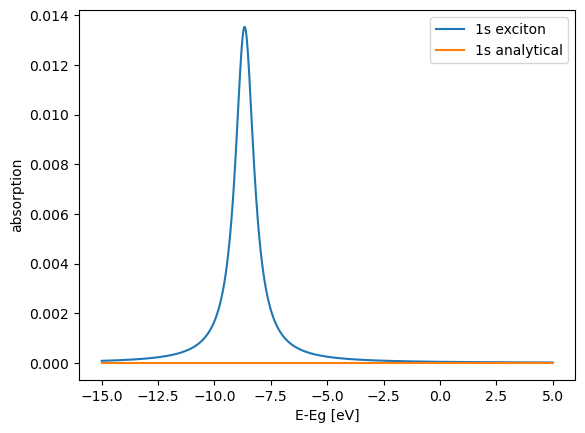

In [4]:
#define functions
energyresolution = 1000
E_start = -0.015 
E_stop = 0.005
omega_list = np.linspace(E_start/hbar,E_stop/hbar,energyresolution)
#@jit(nopython = True)
def phi0(EVs,mu):
    ''' returns the exciton orbital mu value at r = 0'''
    phi0 = 0.
    for j in range(Qdim):
        q = qlist[j] 
        phi0 += q*dQ/2/np.pi*EVs[j,mu]    
    return phi0    

def chi(EWs,EVs, mu, omega):
    return -d_cv**2/epsilon_0 * np.abs(phi0(EVs,mu))**2*(1/(hbar*(omega-EWs[mu]/hbar + 1j*gamma + 1j* d_cv**2 * np.abs(phi0(EVs,mu))**2 *omega_0/(2*hbar*c*n_ref*epsilon_0))))#+1/(hbar*(-omega-E_G/hbar-EWs[mu]/hbar - 1j*gamma - 1j*d_cv**2 * np.abs(phi0(EVs,mu))**2 *omega/(epsilon_0*c*n_ref))))

        
def E_R_mu(EWs,EVs, mu):
    '''E_R/E_0, emitted field per incoming field'''
    E_R = []
    for omega in omega_list:    
        E_R.append(1j*omega_0/(2*epsilon_0 * c*n_ref)* epsilon_0 * chi(EWs,EVs,mu,omega))
    return E_R

def E_R_full(EWs,EVs):
    E_R = np.zeros(energyresolution,dtype = 'complex128')
    for mu in range(len(EWs)):
        E_R = E_R + np.array(E_R_mu(EWs,EVs, mu))
    return E_R

def get_absorption(E_R, energyresolution):
    R = np.absolute(E_R)**2
    T = np.absolute(np.ones(energyresolution, dtype = 'complex_')+E_R) **2
    return np.ones(energyresolution)- R - T

def alpha_1s(omega, EWs, EVs, full = 'False'):
    gamma_R = d_cv**2*np.abs(phi0(EVs,0))**2 * E_G/hbar / (2*hbar*epsilon_0*n_ref*c)
    alpha = (omega+E_G/hbar)/(c*n_ref) * (gamma + gamma_R)/((hbar*omega-EWs[0])**2+hbar*(gamma+gamma_R)**2)
    return alpha

#compute reflection and transmission with coulomb
#alpha_eh_coulomb = get_absorption(E_R(coulomb = True), energyresolution)
#plt.plot(np.linspace(E_start,E_stop,energyresolution),alpha_eh_coulomb, label = 'Matrix inversion coulomb')


#compute reflection and transmission without coulomb
#alpha_eh_free = get_absorption(E_R(coulomb = False), energyresolution)
#plt.plot(np.linspace(E_start,E_stop,energyresolution),alpha_eh_free, label = 'Matrix inversion free')

Qmax = 1.5
Qdim = 500
with open(r"results/alt/Qmax={}_Qdim={}_exciton_EWs.pickle".format(Qmax, Qdim), 'rb') as input_file:
    EWs = pickle.load(input_file)
with open(r"results/alt/Qmax={}_Qdim={}_exciton_EVs.pickle".format(Qmax, Qdim), 'rb') as input_file:
    EVs = pickle.load(input_file)
#omega_list += np.real(EWs[0])/hbar
E_R_0 = E_R_mu(EWs,EVs,0)
plt.plot(1000* hbar*np.array(omega_list),get_absorption(E_R_0, energyresolution), label = '1s exciton')
plt.plot(1000*hbar*np.array(omega_list), np.array([alpha_1s(i, EWs, EVs) for i in omega_list]), label = '1s analytical')

#format plot
plt.xlabel('E-Eg [eV]')
plt.ylabel('absorption')
plt.legend()
plt.show()
#plt.savefig('results/absorption_linear_1s_Qmax={}_Qdim={}.pdf'.format(Qmax, Qdim))
